In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
df.head()

In [4]:
df.shape      
df.columns    
df.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null   object 
 16  

Missing Value

In [6]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

mag_id              1056660
arxiv_id            1042411
pmc_json_files       740918
pdf_json_files       682894
sha                  682894
pmcid                667089
who_covidence_id     573725
pubmed_id            557728
doi                  399880
url                  369726
abstract             235544
journal               87322
s2_id                 80192
authors               23869
publish_time           1814
title                   503
dtype: int64

In [8]:
df_clean = df.dropna(subset=['abstract', 'publish_time'])

In [9]:
df_nlp = df_clean[['title', 'abstract', 'publish_time', 'authors', 'journal']]
df_nlp.shape

(819393, 5)

In [12]:
df_nlp.isnull().sum()

title               0
abstract            0
publish_time        0
authors          5005
journal         77275
dtype: int64

In [11]:
df_nlp = df_nlp.dropna(subset=['title']).reset_index(drop=True)

In [18]:
df_nlp['publish_time'] = pd.to_datetime(df_nlp['publish_time'], errors='coerce')

In [19]:
df_nlp['year'] = df_nlp['publish_time'].dt.year

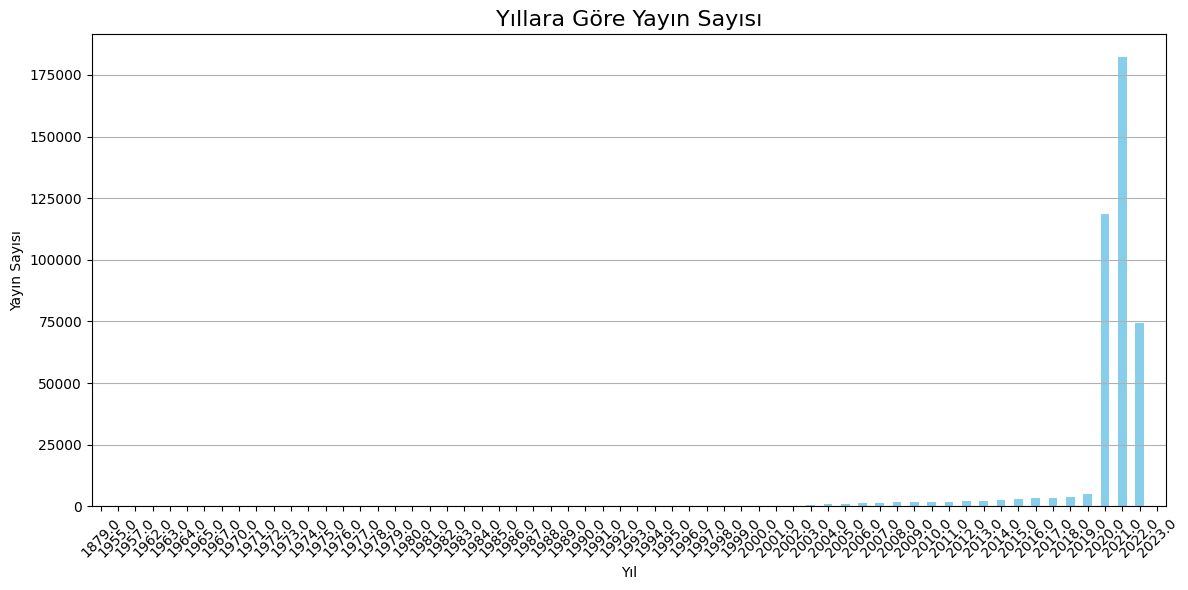

In [20]:
import matplotlib.pyplot as plt

df_nlp['year'] = df_nlp['publish_time'].dt.year
year_counts = df_nlp['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title("Yıllara Göre Yayın Sayısı", fontsize=16)
plt.xlabel("Yıl")
plt.ylabel("Yayın Sayısı")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

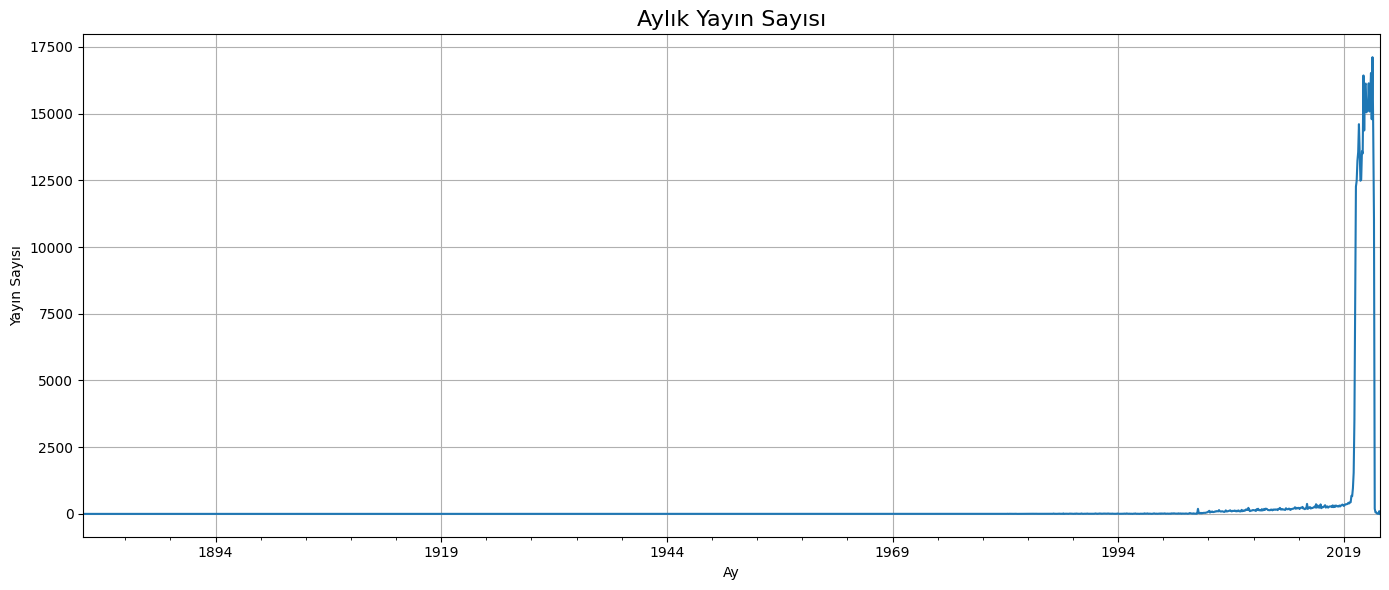

In [21]:
df_nlp['month'] = df_nlp['publish_time'].dt.to_period('M')
monthly_counts = df_nlp['month'].value_counts().sort_index()

plt.figure(figsize=(14,6))
monthly_counts.plot()
plt.title("Aylık Yayın Sayısı", fontsize=16)
plt.xlabel("Ay")
plt.ylabel("Yayın Sayısı")
plt.grid(True)
plt.tight_layout()
plt.show()

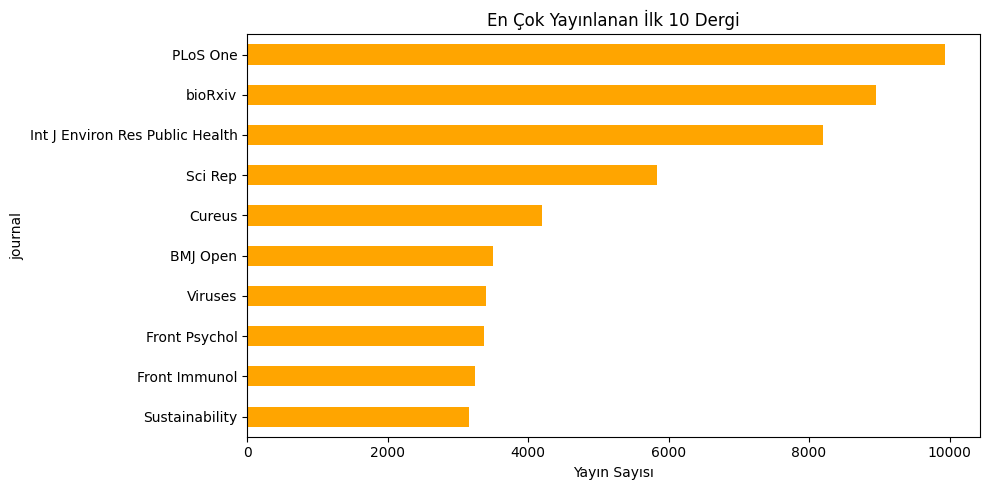

In [15]:
top_journals = df_nlp['journal'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_journals.plot(kind='barh', color='orange')
plt.title("En Çok Yayınlanan İlk 10 Dergi")
plt.xlabel("Yayın Sayısı")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
df_nlp['author_count'].sort_values(ascending=False).head(10)


26945     3572.0
2652      2440.0
63821     2339.0
578412    2070.0
605235    1872.0
254180    1696.0
413011    1681.0
409393    1677.0
207831    1671.0
414028    1671.0
Name: author_count, dtype: float64

In [26]:
# 2–30 yazar aralığı en sağlıklı analiz alanı
df_nlp_filtered = df_nlp[(df_nlp['author_count'] >= 1) & (df_nlp['author_count'] <= 30)]

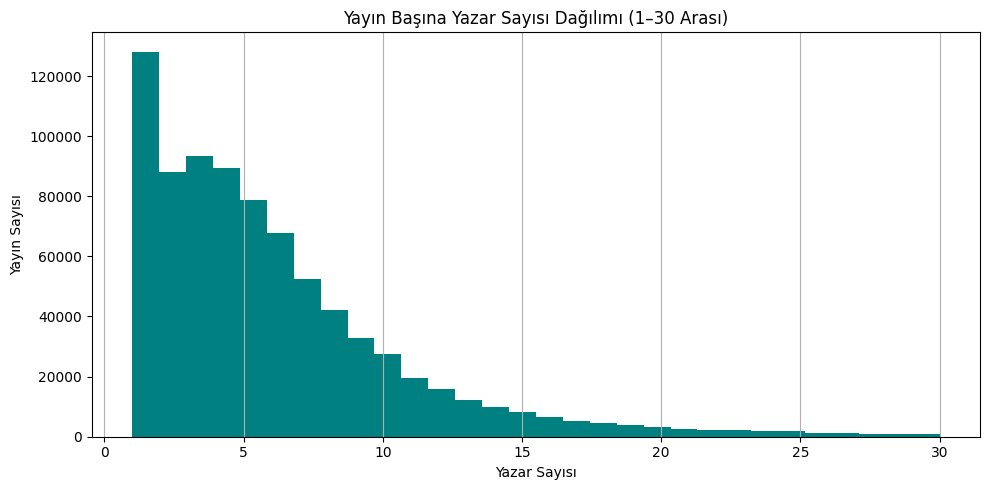

In [27]:
plt.figure(figsize=(10, 5))
df_nlp_filtered['author_count'].hist(bins=30, color='teal')
plt.title("Yayın Başına Yazar Sayısı Dağılımı (1–30 Arası)")
plt.xlabel("Yazar Sayısı")
plt.ylabel("Yayın Sayısı")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [35]:
import string
from wordcloud import WordCloud

# stopwords listesi
stop_words = set([
    'the', 'and', 'for', 'are', 'but', 'not', 'with', 'can', 'has', 'was', 'this',
    'that', 'from', 'have', 'all', 'will', 'which', 'one', 'their', 'they', 'were',
    'had', 'been', 'its', 'also', 'may', 'our', 'who', 'these', 'more', 'some',
    'such', 'use', 'used', 'however', 'between', 'using', 'other', 'into', 'than',
    'after', 'before', 'over', 'under', 'during', 'both', 'those', 'any', 'most'
])

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

df_nlp['clean_abstract'] = df_nlp['abstract'].apply(clean_text)

In [ ]:
all_words = ' '.join(df_nlp['clean_abstract'].dropna())

wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Abstract'larda En Çok Geçen Kelimeler", fontsize=20)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

sample_abstracts = df_nlp['clean_abstract'].dropna().sample(5000, random_state=42)

# TF-IDF vektörleme
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_abstracts)

# Kelime listesi
feature_names = vectorizer.get_feature_names_out()

In [ ]:
import numpy as np
mean_tfidf = tfidf_matrix.mean(axis=0).A1  
tfidf_scores = dict(zip(feature_names, mean_tfidf))
sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:20]

words, scores = zip(*sorted_words)

plt.figure(figsize=(12,5))
plt.barh(words[::-1], scores[::-1], color='coral')
plt.xlabel("TF-IDF Skoru")
plt.title("Abstract'larda En Anlamlı 20 Kelime (TF-IDF)")
plt.tight_layout()
plt.show()
